In [20]:
# to read cobaya input files
from cobaya.yaml import yaml_load_file

# to run the sampler/minimizer
from cobaya.run import run as cobayaRun
# to call CAMB from Cobaya
from cobaya.model import get_model

# to load MCMC chains
from getdist import loadMCSamples, plots

# to analyze the chains
# from getdist.mcsamples import MCSamplesFromCobaya
%matplotlib inline
import matplotlib.pyplot as plt
import getdist.plots as gdplt

import sys

import numpy as np

# Load the Planck samples

Full Planck chain

In [21]:
pathDir = "../../data/planck_chains_2018/COM_CosmoParams_fullGrid_R3.01/"
runParams = "base"
runData = "plikHM_TTTEEE_lowl_lowE"

runPath = pathDir + runParams + "/" + runData + "/base_" + runData


# pathMinimum = runPath + ".minimum"
# pathParamName = runPath + ".paramname"
# pathSamples1 = runPath + "_1.txt"

In [22]:
samplesPlanck = loadMCSamples(runPath)

# Load the DES samples

In [23]:
runParams = "base"
runData = "DES_DESpriors"

runPath = pathDir + runParams + "/" + runData + "/base_" + runData

In [24]:
samplesDES = loadMCSamples(runPath)

# Select a subset of the Planck samples, with low $\Omega_m$

Get the list of parameters info

In [25]:
# List of parameter names
parNamesPlanck = samplesPlanck.getParamNames()
# print(parNamesPlanck)

# Dictionary giving the parameter indices
paramIndices = samplesPlanck._getParamIndices()
iParOmega = str(paramIndices['omegam'])
# print(paramIndices.keys())
# print("Param index for omegam: " + str(paramIndices['omegam']))
# print("Param index for sigma8: " + str(paramIndices['sigma8']))

# get the samples for each parameter
parPlanck = samplesPlanck.getParams()
# print(parPlanck.omegam)

Compute confidence limits / quantiles

In [26]:
# Compute confidence limits / quantiles
samplesPlanck.confidence(parPlanck.omegam, 0., upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 0.05, upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 0.5, upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 0.95, upper=False, start=0, end=None, weights=None), \
samplesPlanck.confidence(parPlanck.omegam, 1., upper=False, start=0, end=None, weights=None)

(0.28441, 0.3028564, 0.3164858, 0.3307111, 0.3516251)

Keep only some of the samples

In [27]:
# fraction of samples to keep
frac = 0.05

# corresponding quantile
qOmegam = samplesPlanck.confidence(parPlanck.omegam, frac, upper=False, start=0, end=None, weights=None)

# samples to keep
I = np.where(parPlanck.omegam <= qOmegam)[0]
print("Keeping " + str(len(I)) + " samples out of " + str(len(parPlanck.omegam)))
print("ie keeping a fraction " + str(len(I) / len(parPlanck.omegam)))

Keeping 1306 samples out of 24497
ie keeping a fraction 0.05331265052863616


In [28]:
# keep only the desired samples
cutSamplesPlanck = samplesPlanck.copy()
cutSamplesPlanck.filter(I)

Plot to check this worked

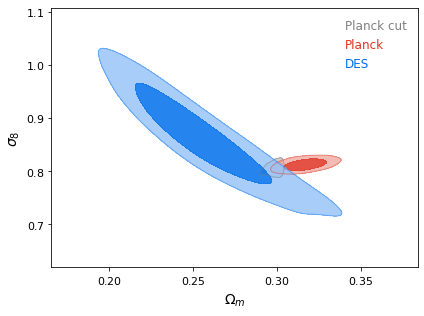

In [29]:
g = plots.get_single_plotter()
g.plot_2d([cutSamplesPlanck, samplesPlanck, samplesDES], ['omegam', 'sigma8'], filled=True)
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True)
# g.export('output_file.pdf')

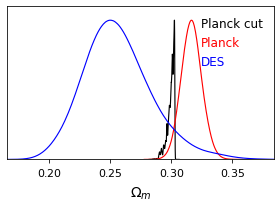

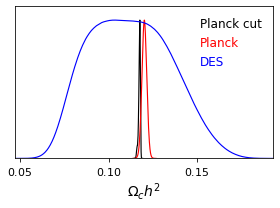

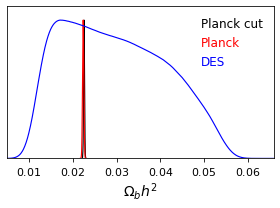

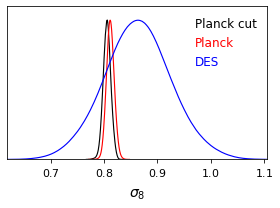

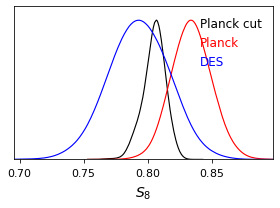

In [30]:
# Show the Omega_m tension
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'omegam', normalized=False)
# g.add_legend(['Planck', 'DES'], colored_text=False, legend_loc='upper right')
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

# Show the Omega_c h^2 tension
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'omegach2', normalized=False)
# g.add_legend(['Planck', 'DES'], colored_text=False, legend_loc='upper right')
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

# Show the Omega_b h^2 tension
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'omegabh2', normalized=False)
# g.add_legend(['Planck', 'DES'], colored_text=False, legend_loc='upper right')
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

# sigma_8 is consistent 
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'sigma8', normalized=False)
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

# S8 is consistent 
g = plots.get_single_plotter(width_inch=4)
g.plot_1d([cutSamplesPlanck, samplesPlanck, samplesDES], 'S8', normalized=False)
g.add_legend(['Planck cut', 'Planck', 'DES'], colored_text=True, legend_loc='upper right')

The tension is mostly in $\Omega_m$

The triangle plot below shows at a low $\Omega_m$ can be compensated with a high $\omega_b$, a high $n_S$, a high $H_0$.
This is confirmed below by looking at the derivatives.

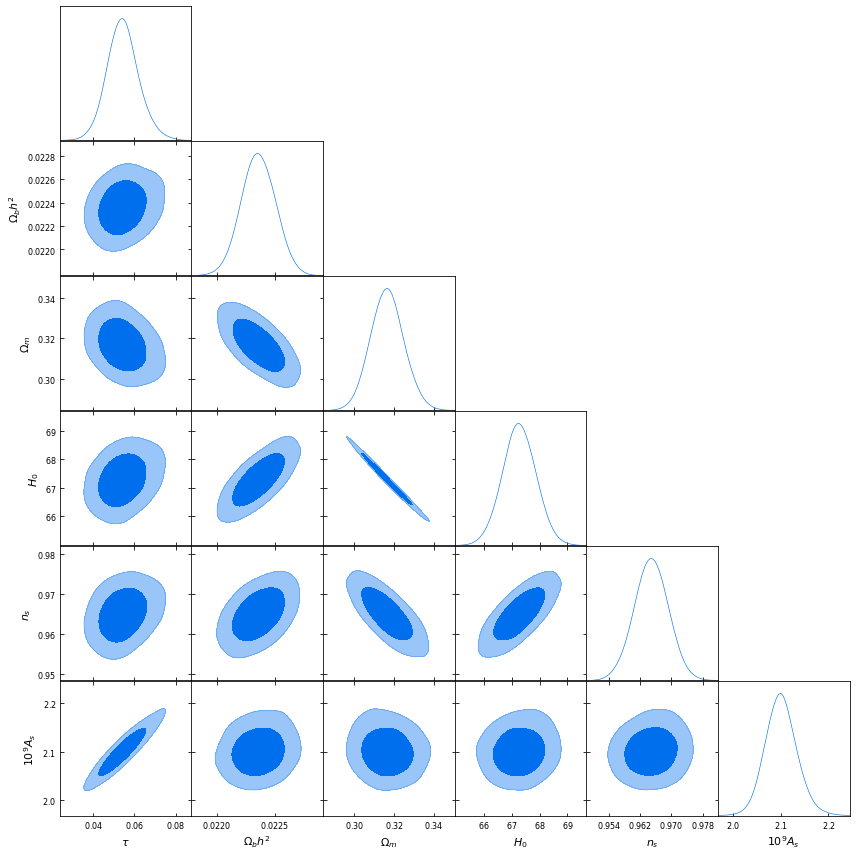

In [31]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot(samplesPlanck, ['tau', 'omegabh2', 'omegam', 'H0', 'ns', 'A'], filled=True)

# Given a chain, compute Cl from the mean posterior parameters

This is where all the magic happens...

In [32]:
def getCambParamsFromSamples(samples):
    # Convert parameter mean array into dictionary
    means = samples.getMeans()
    paramIndices = samples._getParamIndices()
    meansDict = {}
    for key in paramIndices.keys():
        iPar = paramIndices[key]
        meansDict[key] = means[iPar]
    
    # Convert to Cobaya/CAMB input format
    params = {
        'ombh2': meansDict['omegabh2'], 
        'omch2': meansDict['omegach2'], 
        'H0': meansDict['H0'], 
        'tau': meansDict['tau'],
        'As': meansDict['A'] * 1.e-9, 
        'ns': meansDict['ns']}
    
    return params


def getCambParamStdFromSamples(samples):
    # Convert parameter mean array into dictionary
    std = np.sqrt(samples.getVars())
    paramIndices = samples._getParamIndices()
    stdDict = {}
    for key in paramIndices.keys():
        iPar = paramIndices[key]
        stdDict[key] = std[iPar]
    
    # Convert to Cobaya/CAMB input format
    params = {
        'ombh2': stdDict['omegabh2'], 
        'omch2': stdDict['omegach2'], 
        'H0': stdDict['H0'], 
        'tau': stdDict['tau'],
        'As': stdDict['A'] * 1.e-9, 
        'ns': stdDict['ns']}
    
    return params

In [33]:
def getCl(params):
    
    packages_path = '/global/cscratch1/sd/eschaan/project_s8/code/cobaya_exploration/input/cobaya_packages'

    info_fiducial = {
        'params': params,
        'likelihood': {'one': None},
        'theory': {'camb': {"extra_args": {"num_massive_neutrinos": 1}}},
        'packages_path': packages_path}

    l_max = 3000

    model_fiducial = get_model(info_fiducial)

    # Declare our desired theory product
    # (there is no cosmological likelihood doing it for us)
#     model_fiducial.add_requirements({"Cl": {'tt': l_max, 'te': l_max, 'ee': l_max}})
    model_fiducial.add_requirements({"Cl": {'tt': l_max, 'te': l_max, 'ee': l_max},
                                "thetastar": None})

    # Compute and extract the CMB power spectrum
    # (In muK^-2, without l(l+1)/(2pi) factor)
    # notice the empty dictionary below: all parameters are fixed
    model_fiducial.logposterior({})
    ClPlanck = model_fiducial.provider.get_Cl(ell_factor=False, units="muK2")

    # Our fiducial power spectrum
    ClTTPlanck = ClPlanck['tt'][:l_max + 1]
    ClTEPlanck = ClPlanck['te'][:l_max + 1]
    ClEEPlanck = ClPlanck['ee'][:l_max + 1]
    L = np.arange(l_max+1)
    
    # get the derived parameter theta
    thetaStar = model_fiducial.theory['camb']._states[0]['derived_extra']['thetastar']
    
    return L, ClTTPlanck, ClTEPlanck, ClEEPlanck, thetaStar

## Compute Cl for the full Planck Chain

In [34]:
L, ClTTPlanck, ClTEPlanck, ClEEPlanck, thetaStarPlanck = getCl(getCambParamsFromSamples(samplesPlanck))

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


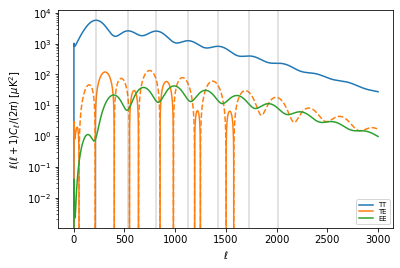

In [50]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.plot(L, L*(L+1.)/(2.*np.pi) * ClTTPlanck, label=r'TT')
plot=ax.plot(L, L*(L+1.)/(2.*np.pi) * ClTEPlanck, label=r'TE')
ax.plot(L, -L*(L+1.)/(2.*np.pi) * ClTEPlanck, ls='--', c=plot[0].get_color())
ax.plot(L, L*(L+1.)/(2.*np.pi) * ClEEPlanck, label=r'EE')
#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**2*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**2*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4, fontsize='x-small', labelspacing=0.1)
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell+1) C_\ell / (2\pi)$ [$\mu$K$^2$]')

plt.show()

## Do it for the cut Planck chain and compare

In [36]:
L, ClTTPlanckCut, ClTEPlanckCut, ClEEPlanckCut, thetaStarPlanckCut = getCl(getCambParamsFromSamples(cutSamplesPlanck))

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


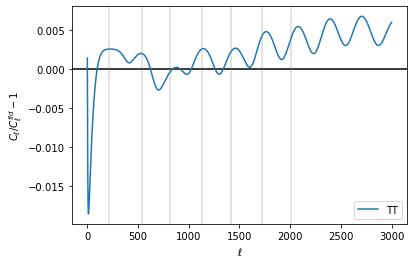

In [51]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axhline(0., c='k')
#
ax.plot(L, ClTTPlanckCut / ClTTPlanck - 1., label=r'TT')
#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**2*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**2*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4)
# ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell / C_\ell^{fid} - 1$')

plt.show()

/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


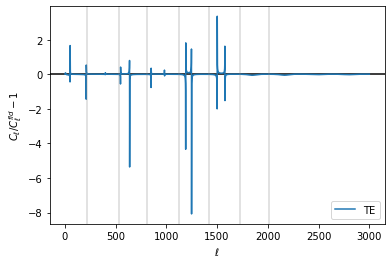

In [52]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axhline(0., c='k')
#
ax.plot(L, ClTEPlanckCut / ClTEPlanck - 1., label=r'TE')
#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**2*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**2*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4)
# ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell / C_\ell^{fid} - 1$')

plt.show()

/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


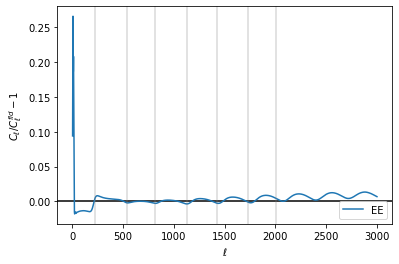

In [53]:
fig=plt.figure(0)
ax=fig.add_subplot(111)
#
ax.axhline(0., c='k')
#
ax.plot(L, ClEEPlanckCut / ClEEPlanck - 1., label=r'EE')
#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**2*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**2*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell / C_\ell^{fid} - 1$')

plt.show()

# Compute response of $C_\ell$ to cosmological parameters

Compute $\partial C_\ell / \partial p$ for $p \in \{ \tau, \omega_b, \omega_c, H_0, n_S, A_S \}$

Choose the high/low values of parameters to estimate the derivatives with finite difference.

In [54]:
# mean values from the full chains
params = getCambParamsFromSamples(samplesPlanck)
# std from the full chain
paramStd = getCambParamStdFromSamples(samplesPlanck)

# print(params)
# print(paramStd)

# choose the low and high values separated by a few sigmas
paramsLow = params.copy()
paramsHigh = params.copy()
for key in params.keys():
    paramsLow[key] = params[key] - 3. *paramStd[key]
    paramsHigh[key] = params[key] + 3. *paramStd[key]

# print(paramsLow)
# print(paramsHigh)

In [55]:
dCldOldTT = {}
dCldOldTE = {}
dCldOldEE = {}
dThetaStardOld = {}

for key in params.keys():
    parNew = params.copy()
    parNew[key] = paramsHigh[key]
    L, ClTTH, ClTEH, ClEEH, thetaStarH = getCl(parNew)
    parNew = params.copy()
    parNew[key] = paramsLow[key]
    L, ClTTL, ClTEL, ClEEL, thetaStarL = getCl(parNew)
    
    dCldOldTT[key] = (ClTTH - ClTTL) / (paramsHigh[key] - paramsLow[key])
    dThetaStardOld[key] = (thetaStarH - thetaStarL) / (paramsHigh[key] - paramsLow[key])

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/homes/e/eschaan/.conda/envs/base3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/homes/e/e

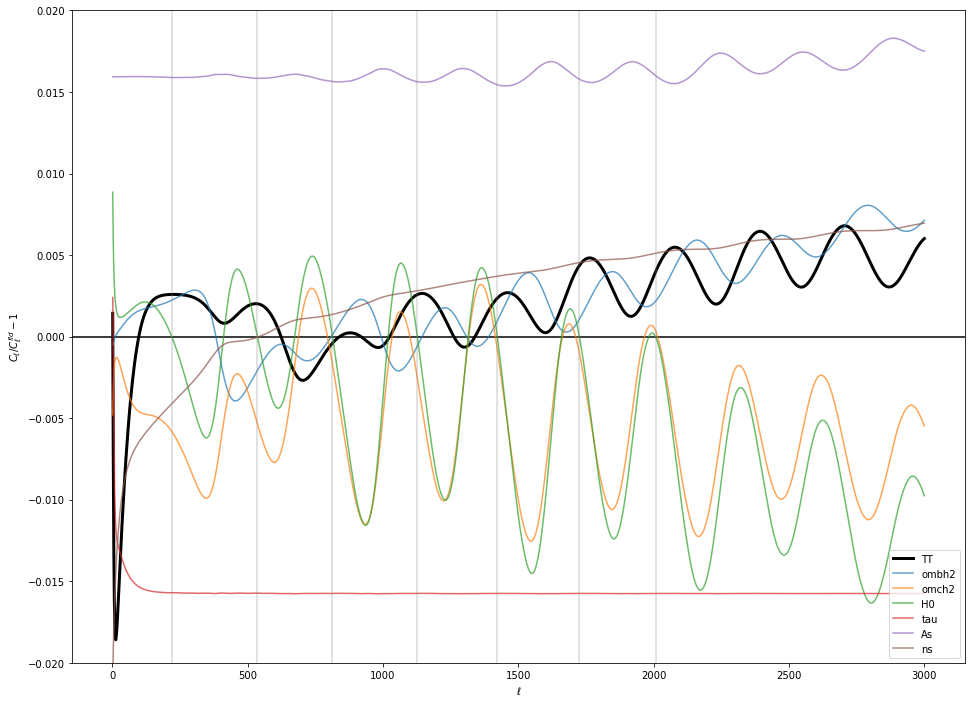

In [56]:
fig=plt.figure(0, figsize=(16, 12))
ax=fig.add_subplot(111)
#
ax.axhline(0., c='k')
#
ax.plot(L, ClTTPlanckCut / ClTTPlanck - 1., 'k', lw=3, label=r'TT')
#
# Add response to cosmological parameters
for key in dCldOldTT.keys():
    ax.plot(L, paramStd[key] * dCldOldTT[key]/ClTTPlanck, alpha=0.7, label=key)

#
# Add quick markers to roughly locate the acoustic peaks
for l in L[50:]:
    value = L[l]**2*ClTTPlanck[l]
    nearbyValues = L[l-10:l+10]**2*ClTTPlanck[l-10:l+10]
    if value==np.max(nearbyValues):
        ax.axvline(l, c='gray', alpha=0.3)
#
ax.legend(loc=4)
# ax.set_yscale('log', nonpositive='clip')
# ax.set_ylim((-0.01, 0.01))
ax.set_ylim((-0.02, 0.02))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_\ell / C_\ell^{fid} - 1$')

plt.show()

- the baryon density shifts the BAO peaks by changing the sound speed up until recombination. It causes the asymmetry between odd and even peaks (baryon loading). It enhances the high ell power spectrum, by reducing Silk damping?
- the dark matter density also shifts the BAO peaks, presumably by changing the sound horizon at recombination? It also changes the overall envelope (by reducing the radiation driving?)
- in this parametrization, $H0$ and the dark matter density have very similar effects. Probably the geometric degeneracy?
- the optical depth and the amplitude of scalar fluctuations have the expected effect.

The triangle plot above showed a degeneracy between low $\Omega_m$ and high $\omega_b, n_S, H_0$.
This seems confirmed here for $\omega_b, n_S$, and maybe less obvious for $H_0$.

# Change parameter set?

Switch from $\{ \tau, \omega_b, \omega_c, H_0, n_S, A_S \}$ to $\{ \tau, \omega_b, \omega_m, \theta_\star, n_S, A_Se^{-2\tau} \}$,
by using the chain rule.

# Call the Planck likelihood, to see which ells are most inconsistent?

# Exploring how to call CAMB from Cobaya

In [43]:
# Convert parameter array into dictionary
means = samplesPlanck.getMeans()
paramIndices = samplesPlanck._getParamIndices()
meansDict = {}
for key in paramIndices.keys():
    iPar = paramIndices[key]
    meansDict[key] = means[iPar]

# Convert to Cobaya input format
fiducial_params = {
    'ombh2': meansDict['omegabh2'], 
    'omch2': meansDict['omegach2'], 
    'H0': meansDict['H0'], 
    'tau': meansDict['tau'],
    'As': meansDict['A'] * 1.e-9, 
    'ns': meansDict['ns']}


packages_path = '/global/cscratch1/sd/eschaan/project_s8/code/cobaya_exploration/input/cobaya_packages'

info_fiducial = {
    'params': fiducial_params,
    'likelihood': {'one': None},
    'theory': {'camb': {"extra_args": {"num_massive_neutrinos": 1}}},
    'packages_path': packages_path}

l_max = 3000

model_fiducial = get_model(info_fiducial)

# Declare our desired theory product
# (there is no cosmological likelihood doing it for us)
# model_fiducial.add_requirements({"Cl": {'tt': l_max, 'te': l_max, 'ee': l_max}})
model_fiducial.add_requirements({"Cl": {'tt': l_max, 'te': l_max, 'ee': l_max},
                                "thetastar": None})

# Compute and extract the CMB power spectrum
# (In muK^-2, without l(l+1)/(2pi) factor)
# notice the empty dictionary below: all parameters are fixed
model_fiducial.logposterior({})
ClPlanck = model_fiducial.provider.get_Cl(ell_factor=False, units="muK2")

# Our fiducial power spectrum
ClTTPlanck = ClPlanck['tt'][:l_max + 1]
ClTEPlanck = ClPlanck['te'][:l_max + 1]
ClEEPlanck = ClPlanck['ee'][:l_max + 1]
L = np.arange(l_max+1)

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.


INFO:camb:Importing *auto-installed* CAMB (but defaulting to *global*).


[camb] Importing *auto-installed* CAMB (but defaulting to *global*).


INFO:camb:Initialized!


[camb] Initialized!


In [44]:
model_fiducial.theory

{'camb.transfers': camb.transfers, 'camb': camb}

In [45]:
model_fiducial.theory['camb'].get_can_provide_params()

{'DAstar',
 'DH',
 'H0',
 'N_eff',
 'TCMB',
 'YHe',
 'Y_p',
 'YpBBN',
 'age',
 'h',
 'kd',
 'keq',
 'ombh2',
 'omch2',
 'omega_de',
 'omegab',
 'omegabh2',
 'omegac',
 'omegach2',
 'omegak',
 'omegal',
 'omegam',
 'omeganu',
 'omk',
 'omnuh2',
 'rdrag',
 'rstar',
 'sigma8',
 'thetad',
 'thetaeq',
 'thetarseq',
 'thetastar',
 'yhe',
 'yheused',
 'zdrag',
 'zeq',
 'zre',
 'zrei',
 'zstar'}

In [46]:
# model_fiducial.theory['camb'].calculate()
# model_fiducial.theory['camb'].get_CAMBdata() 
# model_fiducial.theory['camb'].set_H0_for_theta(meansDict['theta'])
# model_fiducial.theory['camb'].get_allow_agnostic()
model_fiducial.theory['camb']

camb

Get the requested derived parameter.

In [47]:
model_fiducial.theory['camb']._states#.derived_extra
model_fiducial.theory['camb']._states[0]['derived_extra']['thetastar']

1.041110130361714

In [48]:
import inspect
inspect.getmembers(model_fiducial.theory['camb'])

[('__annotations__', {'external_primordial_pk': bool, 'camb': typing.Any}),
 ('__class__', cobaya.theories.camb.camb.camb),
 ('__deepcopy__', <bound method HasLogger.__deepcopy__ of camb>),
 ('__delattr__',
  <method-wrapper '__delattr__' of camb object at 0x2aaae188d350>),
 ('__dict__',
  {'_measured_speed': None,
   '_name': 'camb',
   'packages_path': '/global/cscratch1/sd/eschaan/project_s8/code/cobaya_exploration/input/cobaya_packages',
   'version': None,
   'path': '/global/cscratch1/sd/eschaan/project_s8/code/cobaya_exploration/input/cobaya_packages/code/CAMB',
   'speed': 0.3,
   'stop_at_error': False,
   'extra_args': {'num_massive_neutrinos': 1, 'lmax': 3000},
   'use_renames': False,
   'external_primordial_pk': False,
   'renames': {'omegabh2': 'ombh2',
    'omegach2': 'omch2',
    'omegal': 'omega_de',
    'omegak': 'omk',
    'yhe': 'YHe',
    'yheused': 'YHe',
    'YpBBN': 'Y_p',
    'zrei': 'zre'},
   'log': <Logger camb (INFO)>,
   'timer': None,
   'camb': <module '